In [1]:
import os
import time

import numpy as np
from tqdm import tqdm
from fidelity_simulation import FidelitySimulation
from pulse import RectangularReadoutPulse
from mock_file_creator import shift_s2p_freq_axis_minimal
from floquet_analysis.transmon_resonator_fitter import TransmonResonatorFitter
import matplotlib.pyplot as plt

from fidelity_analysis.utils import setup_plotting

setup_plotting()

In [2]:
# Measured frequencies GHz
f01_meas = 3.845965050
f12_meas = 3.602264855
alpha = f12_meas - f01_meas

fr0_meas = 6.065852884
fr1_meas = 6.064931745
fr2_meas = 6.064094073

fitter = TransmonResonatorFitter(f01_meas, f12_meas, fr0_meas, fr1_meas, fr2_meas)

EJ_fitted, EC_fitted, fr_fitted, g_fitted = fitter.fit_parameters()

fitter.print_results()

Initial guess for [EJ, EC, fr, g]: [8.578861527050124, 0.24370019500000017, 6.0653923145, np.float64(0.09103399089132334)]

--- Fitting Results ---
Fitted EJ: 9.8266 GHz
Fitted EC: 0.2106 GHz
Fitted Resonator Freq (bare, f_r): 6.0650 GHz
Fitted Coupling Strength (g): 0.1017 GHz

Fitted Frequencies (from model with fitted parameters):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0650 GHz
  Resonator freq @ Qubit |1>: 6.0650 GHz
  Resonator freq @ Qubit |2>: 6.0650 GHz

Measured Frequencies (input data):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0659 GHz
  Resonator freq @ Qubit |1>: 6.0649 GHz
  Resonator freq @ Qubit |2>: 6.0641 GHz

Total Squared Error: 1.55e-06


In [3]:
#TEMPLATE_FILE = "template_0ghz_resonator_cut_wide.s2p"
TEMPLATE_FILE = "data_00000_0_ghz.s2p"

current_path = os.path.abspath("")
data_dir_path = os.path.join(current_path, "data")
template_file_path = os.path.join(data_dir_path, TEMPLATE_FILE)

simulation_path = os.path.join(data_dir_path, time.strftime("%Y%m%d-%H%M%S"))


In [4]:
current_path = os.path.abspath("")
data_dir_path = os.path.join(current_path, "data")

In [5]:
f_pulse = fr0_meas * 10 ** 9  # Hz

pulse_length = 2 * 10 ** (-6)  # s

pulse_samples_number = 2 ** 18
rect_readout_pulse = RectangularReadoutPulse(
    carrier_frequency=f_pulse,
    pulse_duration=pulse_length,
    pulse_power_dbm=-123,
    total_signal_time=2*pulse_length,
    pulse_samples_number=pulse_samples_number,
)

rect_readout_pulse.plot_pulse()

 /Users/user/PycharmProjects/qubit_readout_simulation/fidelity_analysis/pulse.py: 224

In [6]:
delta_arr = -1 * np.linspace(1, 5, 100)

In [7]:
# f01_meas - if TEMPLATE_FILE = "template_0ghz_resonator_cut_wide.s2p"
# 0 - if TEMPLATE_FILE = "data_00000_0_ghz.s2p"
original_peak_frequency = 0

shift_s2p_freq_axis_minimal(template_file_path, os.path.join(simulation_path, "original.s2p"), original_peak_frequency)

fidelity = []
for delta in (pbar := tqdm(delta_arr)):
    chi = -g_fitted ** 2 / delta * (1 / (1 + delta / alpha))

    file_state_0 = os.path.join(simulation_path, f"{delta}_0.s2p")
    file_state_1 = os.path.join(simulation_path, f"{delta}_1.s2p")
    shift_s2p_freq_axis_minimal(template_file_path, file_state_0, original_peak_frequency + chi)
    shift_s2p_freq_axis_minimal(template_file_path, file_state_1, original_peak_frequency - chi)

    fidelity_simulation = FidelitySimulation(
        s_parameters_file_state_0=file_state_0,
        s_parameters_file_state_1=file_state_1,
        readout_pulse=rect_readout_pulse,
        IQ_projection_frequency=6.2e9,  # f_fi = 200MHz
        num_iterations=500,
        readout_dt=1e-9,
        plot_pulses=False,
        plot_result=False,
        disable_progress_bar=True,
    )

    result = fidelity_simulation.run()
    fidelity.append(result)
    pbar.set_postfix_str(f"fidelity = {result}")



100%|██████████| 100/100 [06:17<00:00,  3.77s/it, fidelity = 0.679]


In [8]:
fidelity

[0.631,
 0.612,
 0.642,
 0.579,
 0.632,
 0.622,
 0.6,
 0.598,
 0.613,
 0.614,
 0.625,
 0.597,
 0.645,
 0.616,
 0.662,
 0.658,
 0.663,
 0.683,
 0.679,
 0.682,
 0.709,
 0.72,
 0.72,
 0.715,
 0.725,
 0.748,
 0.754,
 0.773,
 0.769,
 0.783,
 0.775,
 0.79,
 0.778,
 0.811,
 0.802,
 0.808,
 0.78,
 0.81,
 0.77,
 0.82,
 0.814,
 0.809,
 0.789,
 0.817,
 0.78,
 0.815,
 0.809,
 0.801,
 0.82,
 0.819,
 0.786,
 0.795,
 0.798,
 0.791,
 0.8,
 0.786,
 0.77,
 0.782,
 0.782,
 0.787,
 0.757,
 0.814,
 0.776,
 0.776,
 0.765,
 0.785,
 0.767,
 0.756,
 0.759,
 0.759,
 0.771,
 0.749,
 0.754,
 0.734,
 0.725,
 0.725,
 0.741,
 0.732,
 0.773,
 0.71,
 0.724,
 0.73,
 0.718,
 0.715,
 0.701,
 0.719,
 0.696,
 0.678,
 0.709,
 0.677,
 0.683,
 0.676,
 0.684,
 0.679,
 0.674,
 0.676,
 0.662,
 0.669,
 0.656,
 0.679]

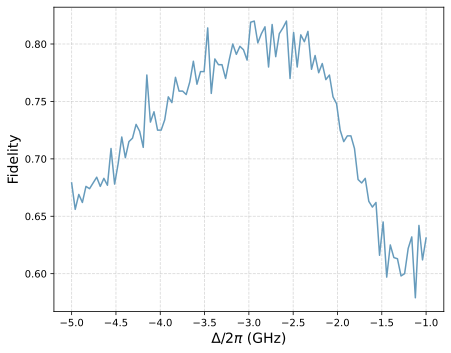

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5.5), sharex=True)

axs.set_xlabel(r'$\Delta/2\pi$ (GHz)')
axs.set_ylabel('Fidelity')
# axs.set_yscale("log")

axs.plot(delta_arr, fidelity)

plt.savefig("detuning_fidelity.png")
plt.show()

In [24]:
import skrf as rf
import matplotlib.pyplot as plt
import numpy as np
import os

fig, ax_s21 = plt.subplots(1, 1, figsize=(8, 7), dpi=300)

cmap = plt.cm.get_cmap('viridis', len(delta_arr))


def plot_file(filepath, iteration_n, states):
    network = rf.Network(filepath)

    frequencies_ghz = network.f
    label = None
    color = cmap(iteration_n)

    if iteration_n == 0 or iteration_n == len(delta_arr) - 1:
        label = rf"S21, State |{states}>" + r"$\text{ with } \Delta/2\pi=$" + str(delta_arr[i]) + "GHz"

    s21_complex = network.s[:, 1, 0]
    ax_s21.plot(frequencies_ghz, np.abs(s21_complex), color=color, label=label)


for i, delta in tqdm(enumerate(delta_arr), total=len(delta_arr)):
    path = os.path.join(simulation_path, f"{delta}_0.s2p")
    plot_file(path, i, 0)
    path = os.path.join(simulation_path, f"{delta}_1.s2p")
    plot_file(path, i, 1)

readout_pulse = RectangularReadoutPulse(
    carrier_frequency=fr0_meas * 10 ** 9,
    pulse_duration=2 * 10 ** (-6),
    pulse_power_dbm=-123,
    total_signal_time=2 * 10 ** (-6),
    pulse_samples_number=2 ** 17,
)

ax_s21.plot(readout_pulse.f_signal_frequencies,
            10 * np.abs(readout_pulse.f_signal),
            c='C2',
            label="Scaled Rect Readout pulse",
            linewidth=3
            )

ax_s21.set_xlabel('Frequency (Hz)')

ax_s21.set_xlim(fr0_meas * 1e9 * 0.999, fr0_meas * 1e9 * 1.001)

ax_s21.legend(loc='lower left')
plt.title(f"S21 and readout pulse, g={g_fitted} GHz")
plt.tight_layout()

plt.savefig("s_params.png")

plt.show()

100%|██████████| 100/100 [00:00<00:00, 170.57it/s]ipykernel_22154/652969521.py: 8


In [11]:
from fidelity_analysis.utils import UnitConverter

power = -123  #dbm
kappa = 0.55 * 1e6 * 2 * np.pi
f_r = 6.065852884e9
UnitConverter().dbm_to_photons(power, f_r, kappa)

72.16714682936474

In [12]:
(6.0655 - 6.066) * 1e9 / 1e6

-0.4999999999997229

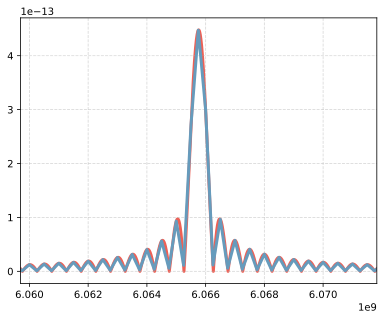

In [25]:
from fidelity_analysis.pulse import Pulse

pulse_samples_number = 2 ** 17

readout_pulse = RectangularReadoutPulse(
    carrier_frequency=fr0_meas * 10 ** 9,
    pulse_duration=2 * 10 ** (-6),
    pulse_power_dbm=-123,
    total_signal_time=2 * 10 ** (-6),
    pulse_samples_number=pulse_samples_number,
)

plt.plot(readout_pulse.f_signal_frequencies,
         np.abs(readout_pulse.f_signal),
         c="C0",
         label=f"Rect Readout pulse: pulse_samples_number = 2^{value}",
         linewidth=3
         )

t_signal = readout_pulse.t_signal
dt = readout_pulse.t_signal_times[1] - readout_pulse.t_signal_times[0]

edges = (fr0_meas * 1e9 * 0.999, fr0_meas * 1e9 * 1.001)
f_signal, f_signal_frequencies = Pulse.to_frequency_domain(t_signal, dt, pulse_samples_number,
                                                           edges, force_use_czt=True)
plt.plot(f_signal_frequencies,
         np.abs(f_signal),
         c="C2",
         label="Rect Readout pulse",
         linewidth=3,
         zorder=-10
         )

plt.xlim(edges)

plt.show()
